In [1]:
!pip install japanize-matplotlib

In [2]:
import os
import zipfile
from glob import glob
from pathlib import Path
import math
import random
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as plab
import japanize_matplotlib
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter('ignore')

from contextlib import contextmanager
from time import time

class Timer:
    '''処理時間を表示するクラス
    with Timer(prefix=f'pred cv={i}'):
        y_pred_i = predict(model, loader=test_loader)
    
    with Timer(prefix='fit fold={} '.format(i)):
        clf.fit(x_train, y_train, 
                eval_set=[(x_valid, y_valid)],  
                early_stopping_rounds=100,
                verbose=verbose)
    '''
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

#最大表示列数の指定
pd.set_option('display.max_columns', 50)
#最大表示行数の指定
pd.set_option('display.max_rows', 50)

def seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
seed(42)

In [3]:
data_path = Path('../data')

In [4]:
# データの生成
# # 建物等級 説明変数:GrLivArea
data = pd.read_csv(os.path.join(data_path, 'house-prices-advanced-regression-techniques/train.csv'))
X = data[(data['MSSubClass']==30) | (data['MSSubClass']==60)][['GrLivArea']].values
Y = data[(data['MSSubClass']==30) | (data['MSSubClass']==60)][['MSSubClass']].values
Y[Y==30] = 0
Y[Y==60] = 1
xLabel = '居住面積: x[平方フィート]'
yLabel = '建物等級ラベルy'

Text(0, 0.5, '建物等級ラベルy')

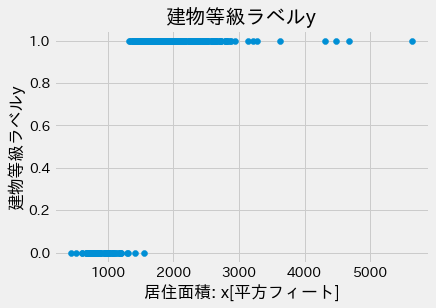

In [5]:
# データの可視化
plt.scatter(X, Y)
plt.title('建物等級ラベルy')
plt.xlabel(xLabel)
plt.ylabel(yLabel)

In [6]:
# データを訓練と評価用に分割
dtrNum = int(len(X)*0.9)    # 学習データ数

# 訓練データ 全体の90%
X_train = X[:dtrNum]
y_train = Y[:dtrNum]
# 評価データ
X_test = X[dtrNum:]
y_test = Y[dtrNum:]

In [7]:
# 入力データの標準化
xMean = np.mean(X_train, axis=0)
xStd = np.std(X_train, axis=0)

X_train = (X_train - xMean) / xStd
X_test = (X_test - xMean) / xStd

In [8]:
class logisticRegression():
    '''ロジスティク回帰'''
    def __init__(self,X,Y):
        '''
        args:
            X: 
                入力データ（データ数×次元数のnumpy.ndarray）
            Y:
                出力データ（データ数×1のnumpy.ndarray）
        '''
        # 学習データの設定
        self.X = X
        self.Y = Y
        self.dNum = X.shape[0]    # 学習データ数
        self.xDim = X.shape[1]    # 入力の次元数
        
        # 行列Xに1の要素を追加
        self.Z = np.concatenate([self.X, np.ones([self.dNum, 1])], axis=1)
        # モデルパラメータの初期値の設定
        self.w = np.random.normal(size=[self.xDim, 1])
        self.b = np.random.normal(size=[1, 1])
        # log(0)回避のための微小値
        self.smallV = 1.0e-5
        
    def update(self, alpha=0.1):
        '''
        最急降下法を用いたモデルパラメータの更新
        args:
            alpha:
                学習率(スカラー実数)
        '''
        # 予測の差の計算
        P, _ = self.predict(self.X)
        error = (P-self.Y)
        
        # パラメータの更新
        grad = 1/self.dNum*np.dot(self.Z.T, error)
        v = np.concatenate([self.w, self.b], axis=0)
        v -= alpha * grad
        
        # パラメータw, b の決定
        self.w = v[:-1]
        self.b = v[[-1]]
        
    def predict(self, x):
        '''
        予測
        args:
            x:
                入力データ（データ数×次元数のnumpy.ndarray）
        '''
        f_x = np.dot(x, self.w)+self.b
        return 1/(1+np.exp(-f_x)), f_x
    
    def CE(self,X,Y):
        '''
        交差エントロピー損失の計算
        args:
            X:
                入力データ（データ数×次元数のnumpy.ndarray）
            Y:
                出力データ（データ数×１のnumpy.ndarray）
        '''
        P,_ = self.predict(X)
        return -np.mean(Y*np.log(P+self.smallV)+(1-Y)*np.log(1-P+self.smallV))
    
    def accuracy(self,X,Y,thre=0.5):
        '''
        交差エントロピー損失の計算
        args:
            X:
                入力データ（データ数×次元数のnumpy.ndarray）
            Y:
                出力データ（データ数×１のnumpy.ndarray）
            thre:
                閾値（スカラー）
        '''
        P,_ = self.predict(X)
        
        # 2値化
        P[P>thre] = 1
        P[P<=thre] = 0
        
        # 正解率
        accuracy = np.mean(Y==P)
        return accuracy

    def plotModel1D(self,X=[],Y=[],xLabel='',yLabel='',fName=''):
        '''
        真値と予測値のプロット（入力ベクトルが1次元の場合）
        args:
            X:
                入力データ（データ数×次元数のnumpy.ndarray）
            Y:
                出力データ（データ数×１のnumpy.ndarray）
            xLabel:
                x軸のラベル（文字列）
            yLabel:
                y軸のラベル（文字列）
            fName:
                画像の保存先（文字列）
        '''
        fig = plt.figure(figsize=(6,4),dpi=100)

        # 予測値
        P,_ = self.predict(X)

        # 真値と予測値のプロット
        plt.plot(X,Y,'b.',label='真値')
        plt.plot(X,P,'r.',label='予測')
        
        # 各軸の範囲とラベルの設定
        plt.yticks([0,0.5,1])
        plt.ylim([-0.1,1.1])
        plt.xlim([np.min(X),np.max(X)])
        plt.xlabel(xLabel,fontSize=14)
        plt.ylabel(yLabel,fontSize=14)
        plt.legend()

        # グラフの表示またはファイルへの保存
        if len(fName):
            plt.savefig(fName)
        else:
            plt.show()
            
    def plotModel2D(self,X=[],Y=[],xLabel='',yLabel='',title='',fName=''):
        '''
        真値と予測値のプロット（入力ベクトルが2次元の場合）
        args:
            X:
                入力データ（データ数×次元数のnumpy.ndarray）
            Y:
                出力データ（データ数×１のnumpy.ndarray）
            xLabel:
                x軸のラベル（文字列）
            yLabel:
                y軸のラベル（文字列）
            title:
                タイトル（文字列）
            fName:
                画像の保存先（文字列）
        '''
        #fig = plt.figure(figsize=(6,4),dpi=100)
        plt.close()
        
        # 真値のプロット（クラスごとにマーカーを変更）
        plt.plot(X[Y[:,0]==0,0],X[Y[:,0]==0,1],'cx',markerSize=14,label='ラベル0')
        plt.plot(X[Y[:,0]==1,0],X[Y[:,0]==1,1],'m.',markerSize=14,label='ラベル1')

        # 予測値のメッシュの計算
        X1,X2 = plab.meshgrid(plab.linspace(np.min(X[:,0]),np.max(X[:,0]),50),plab.linspace(np.min(X[:,1]),np.max(X[:,1]),50))
        Xmesh = np.hstack([np.reshape(X1,[-1,1]),np.reshape(X2,[-1,1])])
        Pmesh,_ = self.predict(Xmesh)
        Pmesh = np.reshape(Pmesh,X1.shape)

        # 予測値のプロット
        CS = plt.contourf(X1,X2,Pmesh,linewidths=2,cmap='bwr',alpha=0.3,vmin=0,vmax=1)

        # カラーバー
        CB = plt.colorbar(CS)
        CB.ax.tick_params(labelsize=14)

        # 各軸の範囲とラベルの設定
        plt.xlim([np.min(X[:,0]),np.max(X[:,0])])
        plt.ylim([np.min(X[:,1]),np.max(X[:,1])])
        plt.title(title,fontSize=14)
        plt.xlabel(xLabel,fontSize=14)
        plt.ylabel(yLabel,fontSize=14)
        plt.legend()

        # グラフの表示またはファイルへの保存
        if len(fName):
            plt.savefig(fName)
        else:
            plt.show()

    def plotEval(self,trEval,teEval,ylabel='loss',fName=''):
        '''
        学習と評価損失のプロット
        args:
            trEval: 
                学習の損失
            teEval:
                評価の損失
            yLabel:
                y軸のラベル（文字列）
            fName:
                画像の保存先（文字列）
        '''
        fig = plt.figure(figsize=(6,4),dpi=100)
        
        # 損失のプロット
        plt.plot(trEval,'b',label='train')
        plt.plot(teEval,'r',label='evaluation')
        
        # 各軸の範囲とラベルの設定
        plt.xlabel('epoch',fontSize=14)
        plt.ylabel(ylabel,fontSize=14)
        plt.ylim([0,1.1])
        plt.legend()
        
        # グラフの表示またはファイルへの保存
        if len(fName):
            plt.savefig(fName)
        else:
            plt.show()

In [9]:
myModel = logisticRegression(X_train,y_train)

trLoss = []
teLoss = []

epochs = 1000
for epoch in range(epochs+1):
    trLoss.append(myModel.CE(X_train,y_train))
    teLoss.append(myModel.CE(X_test,y_test))
    
    if epoch%100==0:
        print(f'epoch:{epoch}')
        print(f'モデルパラメータ:\nw={myModel.w},\nb={myModel.b}')
        print(f'平均交差エントロピー損失={myModel.CE(X_test,y_test):.2f}')
        print(f'正解率={myModel.accuracy(X_test,y_test):.2f}')
        print('-'*42)
        
    # モデルパラメータの更新
    myModel.update(alpha=0.5)

epoch:0
モデルパラメータ:
w=[[0.49671415]],
b=[[-0.1382643]]
平均交差エントロピー損失=0.63
正解率=0.51
------------------------------------------
epoch:100
モデルパラメータ:
w=[[3.07417772]],
b=[[2.86698402]]
平均交差エントロピー損失=0.13
正解率=0.97
------------------------------------------
epoch:200
モデルパラメータ:
w=[[4.02514968]],
b=[[3.64321221]]
平均交差エントロピー損失=0.10
正解率=0.97
------------------------------------------
epoch:300
モデルパラメータ:
w=[[4.64938072]],
b=[[4.15250045]]
平均交差エントロピー損失=0.09
正解率=0.97
------------------------------------------
epoch:400
モデルパラメータ:
w=[[5.12452749]],
b=[[4.53820774]]
平均交差エントロピー損失=0.08
正解率=0.97
------------------------------------------
epoch:500
モデルパラメータ:
w=[[5.51220156]],
b=[[4.85127355]]
平均交差エントロピー損失=0.08
正解率=0.97
------------------------------------------
epoch:600
モデルパラメータ:
w=[[5.84164968]],
b=[[5.11606777]]
平均交差エントロピー損失=0.07
正解率=0.97
------------------------------------------
epoch:700
モデルパラメータ:
w=[[6.12923223]],
b=[[5.34625321]]
平均交差エントロピー損失=0.07
正解率=0.97
------------------------------------------
ep

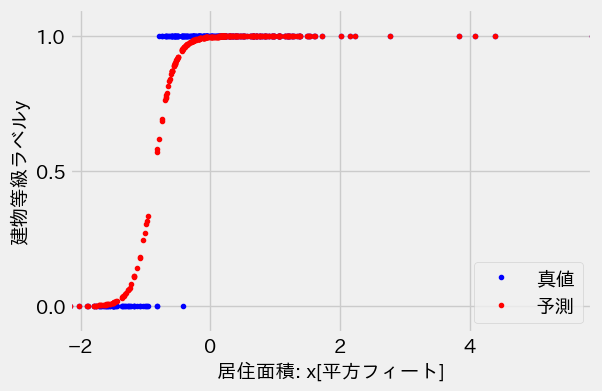

In [10]:
# 真値と予測値のプロット
dataType = 1
if X_train.shape[1] == 1:
    myModel.plotModel1D(X=X_train,Y=y_train,xLabel=xLabel,yLabel=yLabel,fName=f'../results/logistic_result_train_{dataType}.pdf')
elif X_train.shape[1] == 2:
    myModel.plotModel2D(X=X_train,Y=y_train,xLabel=xLabel,yLabel=yLabel,fName=f'../results/logistic_result_train_{dataType}.pdf')

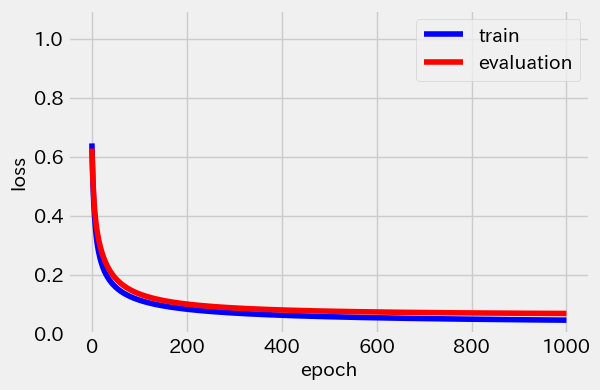

In [11]:
# 学習と評価損失のプロット
myModel.plotEval(trLoss,teLoss,fName=f'../results/logistic_CE_{dataType}.pdf')
# myModel.plotLoss(trLoss,teLoss)

## 複数データ

In [12]:
# データの生成
# # 建物等級 説明変数:GrLivArea
data = pd.read_csv(os.path.join(data_path, 'house-prices-advanced-regression-techniques/train.csv'))
X = data[(data['MSSubClass']==30) | (data['MSSubClass']==60)][['GrLivArea','GarageArea']].values
Y = data[(data['MSSubClass']==30) | (data['MSSubClass']==60)][['MSSubClass']].values
Y[Y==30] = 0
Y[Y==60] = 1
xLabel = '居住面積: x[平方フィート]'
yLabel = '車庫面積x[平方フィート]'

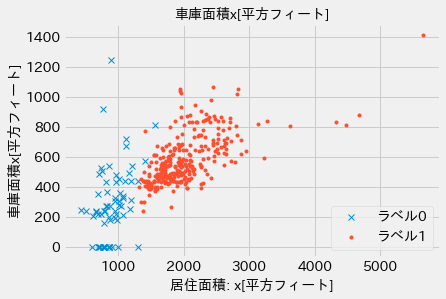

In [19]:
# 可視化
plt.plot(X[Y[:,0]==0,0],X[Y[:,0]==0,1],'x', label='ラベル0')
plt.plot(X[Y[:,0]==1,0],X[Y[:,0]==1,1],'.', label='ラベル1')

plt.title('車庫面積x[平方フィート]',fontSize=14)
plt.xlabel(xLabel,fontSize=14)
plt.ylabel(yLabel,fontSize=14)
plt.legend()

In [13]:
# データを訓練と評価用に分割
dtrNum = int(len(X)*0.9)    # 学習データ数

# 訓練データ 全体の90%
X_train = X[:dtrNum]
y_train = Y[:dtrNum]
# 評価データ
X_test = X[dtrNum:]
y_test = Y[dtrNum:]

In [14]:
# 入力データの標準化
xMean = np.mean(X_train, axis=0)
xStd = np.std(X_train, axis=0)

X_train = (X_train - xMean) / xStd
X_test = (X_test - xMean) / xStd

In [15]:
myModel = logisticRegression(X_train,y_train)

trLoss = []
teLoss = []

epochs = 1000
for epoch in range(epochs+1):
    trLoss.append(myModel.CE(X_train,y_train))
    teLoss.append(myModel.CE(X_test,y_test))
    
    if epoch%100==0:
        print(f'epoch:{epoch}')
        print(f'モデルパラメータ:\nw={myModel.w},\nb={myModel.b}')
        print(f'平均交差エントロピー損失={myModel.CE(X_test,y_test):.2f}')
        print(f'正解率={myModel.accuracy(X_test,y_test):.2f}')
        print('-'*42)
        
    # モデルパラメータの更新
    myModel.update(alpha=0.5)

epoch:0
モデルパラメータ:
w=[[0.64768854]
 [1.52302986]],
b=[[-0.23415337]]
平均交差エントロピー損失=0.54
正解率=0.70
------------------------------------------
epoch:100
モデルパラメータ:
w=[[2.63622404]
 [0.56844826]],
b=[[2.88178609]]
平均交差エントロピー損失=0.13
正解率=0.97
------------------------------------------
epoch:200
モデルパラメータ:
w=[[3.71311798]
 [0.31797502]],
b=[[3.59779514]]
平均交差エントロピー損失=0.10
正解率=0.97
------------------------------------------
epoch:300
モデルパラメータ:
w=[[4.40390512]
 [0.20677027]],
b=[[4.09204854]]
平均交差エントロピー損失=0.09
正解率=0.97
------------------------------------------
epoch:400
モデルパラメータ:
w=[[4.92458552]
 [0.13411025]],
b=[[4.47065211]]
平均交差エントロピー損失=0.08
正解率=0.97
------------------------------------------
epoch:500
モデルパラメータ:
w=[[5.34848604]
 [0.07664167]],
b=[[4.7781291]]
平均交差エントロピー損失=0.08
正解率=0.97
------------------------------------------
epoch:600
モデルパラメータ:
w=[[5.70891858]
 [0.02744178]],
b=[[5.03769689]]
平均交差エントロピー損失=0.07
正解率=0.97
------------------------------------------
epoch:700
モデルパラメータ:
w=[[ 6.02

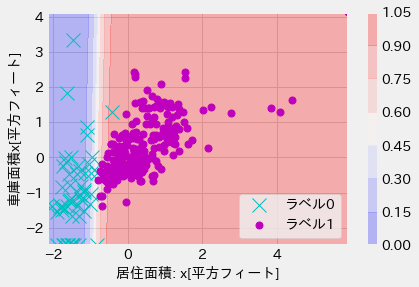

In [16]:
# 真値と予測値のプロット
dataType = 2
if X_train.shape[1] == 1:
    myModel.plotModel1D(X=X_train,Y=y_train,xLabel=xLabel,yLabel=yLabel,fName=f'../results/logistic_result_train_{dataType}.pdf')
elif X_train.shape[1] == 2:
    myModel.plotModel2D(X=X_train,Y=y_train,xLabel=xLabel,yLabel=yLabel,fName=f'../results/logistic_result_train_{dataType}.pdf')

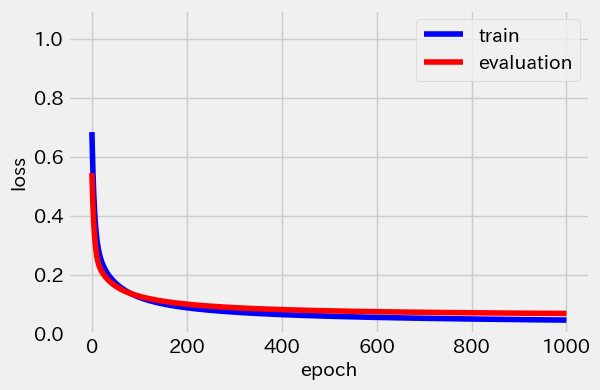

In [17]:
# 学習と評価損失のプロット
myModel.plotEval(trLoss,teLoss,fName=f'../results/logistic_CE_{dataType}.pdf')
# myModel.plotLoss(trLoss,teLoss)